---
<div align="center">

<img align="center" src="https://www.di.uoa.gr/themes/corporate_lite/logo_en.png" width="500"/>

<hr>


</div>

<div align="center">
<h1><strong>YS19 - Artificial Intelligence II <br>Deep Learning for NLP</strong></h1>
</div>

<hr>

<div align="center">
<h2>Homework #3 - RNNs/LSTMs/GRUs (1)</h2>
</div>




---


# Import of packages and libraries including PyTorch



In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
        This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


# Vanilla RNN

---



## **What's an RNN**❓ 


RNNs model **sequential data**, meaning they have **sequential memory**. 
An RNN takes in different kind of inputs (text, words, letters, parts of an image, sounds, etc.) in the form of vectors.

It returns different kinds of outputs, such as the next word/letter in a sequence or paired with an feed-forward NN it can return a class etc.

**Hidden states**

From the relationship between hidden layer outputs $h_t$  and $h_{t-1}$ of adjacent time steps, we know that these variables captured and retained the sequence’s historical information up to their current time step, just like the state or memory of the neural network’s current time step. Therefore, such a **hidden layer output is called a hidden state**.

> It is noteworthy that __hidden layers__ and __hidden states__ refer to two very different concepts. Hidden layers are, as explained, layers that are hidden from view on the path from input to output. Hidden states are technically speaking inputs to whatever we do at a given step, and they can only be computed by looking at data at previous time steps.


**How RNN works**:

- It uses previous information to affect later ones
- The loop: passes the input forward sequentialy, while *retaining information* about it
- This info is stored in the *hidden state*
- There are only 3 matrices  that contain weights as parameters. These *DON'T change* with the input, they stay the same through the entire sequence.

<img src="https://github.com/AI-team-UoA/Courses/blob/main/Deep-Learning-for-NLP-YS19/RNNs/images/rnn_function.png?raw=true" width="1000">







## Language Model in pure pyΤorch

Neural Nets in general can have different number of inputs/outputs.

This is according to the application.

<br>



<img src="https://github.com/AI-team-UoA/Courses/blob/main/Deep-Learning-for-NLP-YS19/RNNs/images/input_outputs.jpeg?raw=true" width="1000">

We want to build a simple language model that can learn to predict the next letter in a sequence of letters.

<img src="https://github.com/AI-team-UoA/Courses/blob/main/Deep-Learning-for-NLP-YS19/RNNs/images/rnn_showcase.png?raw=true" width="1000">

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):

        # Syntactic sugar
        super().__init__()
        
        # Needed to formulate the layer shapes
        # The size of the embeddings or the # of features
        self.num_features = num_features

        # The hidden layer mapping size
        self.num_hidden = num_hidden
        
        # The size of the output classes
        self.num_classes = num_classes
        
        # Network Parameters (default requires_grad=True)
        # Input
        self.Wxh = nn.Parameter(torch.randn((num_features, num_hidden)))
        self.Whh = nn.Parameter(torch.randn((num_hidden, num_hidden)))
        self.bh  = nn.Parameter(torch.zeros((num_hidden)))
        
        # Hidden -> Output
        self.Why = nn.Parameter(torch.randn((num_hidden, self.num_classes)))
        self.by = nn.Parameter(torch.zeros((self.num_classes))) 
        
        # Activation
        self.tanh = nn.Tanh()
    
    def init(self):
        # Initialize hidden state to zero
        self.h = torch.zeros((self.num_hidden))
        
    def forward(self, x):
        self.h = self.tanh((x @ self.Wxh) + (self.h @ self.Whh) + self.bh)
        y_output = self.h @ self.Why + self.by
        return y_output

## Questions on pytorch?
 - Why super() ...?
 - Why Parameter and no Tensor?
 > Parameter is a kind of Tensor that is to be considered a module parameter. Parameters are Tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in parameters() iterator. Assigning a Tensor doesn’t have such effect. This is because one might want to cache some temporary state, like last hidden state of the RNN, in the model. If there was no such class as Parameter, these temporaries would get registered too.
 - Which activation function for hidden layers? [Check out this for details](https://cs231n.github.io/neural-networks-1/).
     - In sort: ReLU (or LeakyRelU) >> tanh >> sigmoid
     
 - @? [PEP-0465](https://legacy.python.org/dev/peps/pep-0465/)

In [4]:
num_features, num_hidden, num_classes = 4, 3, 4
model = VanillaRNN(num_features, num_hidden, num_classes)

# Printing out the module parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

Wxh torch.Size([4, 3])
Whh torch.Size([3, 3])
bh torch.Size([3])
Why torch.Size([3, 4])
by torch.Size([4])


## Simple Mapper to encode a sequence of chars to vectors


### One-Hot encoding

When dealing with such categorical data, the most common strategy is to represent each item by a one-hot encoding. A one-hot encoding is a vector whose length is given by the size of the vocabulary N, where all entries are set to 0, except for the entry corresponding to our token, which is set to 1. For example, if the vocabulary had 5 elements, then the one-hot vectors corresponding to indices 0 and 2 would be the following.

```
[1, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
```

In [14]:
import unicodedata
import string

# Flag to limit the vocabulary to lowercase letters only
lowercase_only = False
if lowercase_only:
    # the lowercase letters (a-z) + some special chars will be in our vocab
    characters = " .,;!-':" + string.ascii_lowercase
else:
    # All letters (a-Z) + some special chars will be in our vocab
    characters = " .,;!-':" + string.ascii_letters
    
print(f'Vocabulary: {characters} \nSize: {len(characters)}')

class SequenceHandler:
    """
      Utility class to vectorize a sequence of characters. 
      We will create one instance of this class for every string we want to feed to our model.
    """
    def __init__(self, original_string, max_number_char=-1, lowercase_only=False):
        """
        - original_string: str, the input string to vectorize
        - max_number_char: int, whether we want to pad or trim the input sequence. 
            If max_number_char > 0 the input sequence will be trimmed to max_number_char or will be padded with whitespace
        - lowercase_only: bool,
            If True, lowercase the input string first to avoid dropping OOV chars.
        """
        
        # If lowercase vocab, lowercase the input string as well to avoid dropping the
        # OOV capital letters
        if lowercase_only:
            input_string = original_string.lower()
        else:
            input_string = original_string

        # Keep only letters in the vocab
        input_string= "".join([s for s in input_string if s in characters])
        
        # Trim or pad the sequence
        if max_number_char > 0 :
            if len(input_string) < max_number_char:
                input_string = input_string + " " * (max_number_char - len(input_string))
            else:
                input_string = input_string[:max_number_char]
            
        print(f'Processed string: {original_string} --> {input_string}')
        
        # Save the input string
        self.string = input_string
        self.num_characters = len(characters)
        
        # Mapper to char and back
        self.char_to_idx = { ch : i for i, ch in enumerate(characters) }
        self.idx_to_char = { i : ch for ch, i in self.char_to_idx.items() }
        
        self.ohe = self.init_ohe()
        print("One-hot encoding: ")
        print(self.ohe.shape)
        print(self.ohe)
        self._process()
        self._process_for_cl()
        
    def init_ohe(self):
        """
        This will create a matrix with one hot encoded vectors for each char in the vocab.
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding of all the chars in the vocab.
        """
        one_hot = np.zeros((self.num_characters,self.num_characters), dtype=np.int8)
        np.fill_diagonal(one_hot, 1)
        return one_hot
    
    def _process(self):
        """
        This will create the X and y variables of the instance. 
        In X we will store the vector representation of the sequence in a (N_seq - 1) x embedding_size tensor.
        In y we will store the corresponding correct char index value for the next character in the sequence. This will be a tensor of size N_seq, containing integers.
        """
        data_torch = torch.tensor([self.ohe[self.char_to_idx[char]] for char in self.string])
        self.X = data_torch[:-1].float()
        self.y = torch.argmax(data_torch[1:], dim=1).long()
      
    # For other purposes
    def _process_for_cl(self):
        """
        This will create the X_cl variable of the instance. 
        In X_cl we will store the vector representation of the sequence in a (N_seq) x embedding_size tensor.
        """
        data_torch = torch.tensor([self.ohe[self.char_to_idx[char]] for char in self.string])
        self.X_cl = data_torch[:].float()
    
    def __repr__(self):
        return self.string
        
    def make_onehot(self, char):
        return torch.Tensor(self.ohe[self.char_to_idx[char]]).float()
    
    def __repr__(self):
        return self.string

Vocabulary:  .,;!-':abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ 
Size: 60


In [15]:
data = SequenceHandler('hello')
print(f'{data} (length: {len(data.string)})')
print(f'X vectors: {data.X.shape}, Y: {data.y.shape}')
print(f'Input: (in chars)')
print([data.idx_to_char[x_i.item()] for x_i in data.X.argmax(dim=1)])
print(f'Corresponding target output: (in chars)')
print([data.idx_to_char[y_i.item()] for y_i in data.y])

Processed string: hello --> hello
One-hot encoding: 
(60, 60)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
hello (length: 5)
X vectors: torch.Size([4, 60]), Y: torch.Size([4])
Input: (in chars)
['h', 'e', 'l', 'l']
Corresponding target output: (in chars)
['e', 'l', 'l', 'o']


In [8]:
class RNN(nn.Module):
    """
      Wrapper class that will hold the interface for VanillaRNN, LSTMs and GRUs
    """
    cells = {
        "vanilla" : VanillaRNN,
        # "LSTM"    : LSTMCell, # for future implementations
        # "GRU"     : GRUCell # for future implementations
    }
    
    def __init__(self, 
                 num_features, 
                 num_hidden=10, 
                 num_classes=None, 
                 cell_type='vanilla'):
        super().__init__()

        # We default to LM
        if num_classes == None:
            num_classes = num_features
        self.cell_type = cell_type
        print(f"Creating RNN with cell: {cell_type}")
        self.cell = RNN.cells[cell_type](num_features, num_hidden, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for param in self.cell.parameters():

            # Keep track of gradient for backprop
            param.requires_grad_(True)
            
            # If we deal with weights xavier initialization
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data)
            
            # Else is a bias term so all zeros
            else: 
                nn.init.zeros_(param.data)
                
    def forward(self, X):

        # Setup outputs container (the output at each step)
        outputs = torch.zeros_like(X)
        
        # Iterate through sequence
        self.cell.init()
        for i, x in enumerate(X):
            outputs[i] = self.cell(x)
            
        return outputs
    
    def generate(self, 
                 data, 
                 init_char, 
                 num_steps=5, 
                 output_type='char'):
        """
        Generate text of length num_steps given an initial character.
        """
        # Check for valid character
        if init_char not in data.char_to_idx:
            avail_chars = ",".join(data.char_to_idx.keys())
            print(f"Character not in vocab. Pick another from: {avail_chars}")
            return
        
        # Use both see for example: https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/3
        with torch.no_grad():
            self.eval()

            # Setup feed that will be used to create the next char
            feed = torch.zeros((num_steps, data.num_characters))

            # First time feed buffer contains only the first string
            feed[0] = data.make_onehot(init_char).unsqueeze(dim=0)
            
            # The output starts obv. with the first given char
            output = [init_char]
            
            # For the rest of wanted chars
            for predict_i in range(num_steps-1):
                
                # Update the feed buffer up to the current char
                feed_in = feed[:predict_i+1]
                
                # Predict the next char in the sequence
                next_chars = self(feed_in)[-1]
                
                # Get the next char id
                next_char_idx = torch.argmax(next_chars).item()
                
                # Get the next char
                next_char = data.idx_to_char[next_char_idx]
                
                # One hot encode the char and update the feed buffer
                feed[predict_i+1] = data.make_onehot(next_char).unsqueeze(dim=0)
                
                # Update the final output
                output.append(next_char)

            # Concatenate the chars predicted
            if output_type == 'char':
                output_str = "".join(output)
            elif output_type == 'word':
                output_str = " ".join(output)
            else:
                raise NotImplementedError

            return output_str

Comments:

- The __forward method__ defines how to compute the output and hidden state at any time step, given the current input and the state of the model at the previous time step. Note that the RNN model loops through the outermost dimension of inputs, updating the hidden state one time step at a time.

#### Setup

In [17]:
CELL_TYPE = 'vanilla' # vanilla
num_hidden = 50
net = RNN(num_features=60, 
          num_hidden=num_hidden, 
          cell_type=CELL_TYPE)

for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

LR = 0.001
optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

N_EPOCHS = 100
print_every_ = 1
end_early = False
seq_i = ""        
losses = []

Creating RNN with cell: vanilla
cell.Wxh torch.Size([60, 50])
cell.Whh torch.Size([50, 50])
cell.bh torch.Size([50])
cell.Why torch.Size([50, 60])
cell.by torch.Size([60])


Epoch 1/100 -- Loss: 4.1822 -- Network out: ht-U-
Epoch 2/100 -- Loss: 4.1369 -- Network out: ht-U-
Epoch 3/100 -- Loss: 4.0920 -- Network out: ht-U-
Epoch 4/100 -- Loss: 4.0475 -- Network out: ht-U-
Epoch 5/100 -- Loss: 4.0033 -- Network out: ht-U-
Epoch 6/100 -- Loss: 3.9594 -- Network out: ht-U-
Epoch 7/100 -- Loss: 3.9157 -- Network out: ht-U-
Epoch 8/100 -- Loss: 3.8720 -- Network out: ht-U-
Epoch 9/100 -- Loss: 3.8282 -- Network out: ht-U-
Epoch 10/100 -- Loss: 3.7843 -- Network out: ht-U-
Epoch 11/100 -- Loss: 3.7401 -- Network out: hehl-
Epoch 12/100 -- Loss: 3.6956 -- Network out: hehl-
Epoch 13/100 -- Loss: 3.6506 -- Network out: hehlo
Epoch 14/100 -- Loss: 3.6049 -- Network out: hehlo
Epoch 15/100 -- Loss: 3.5586 -- Network out: hehlo
Epoch 16/100 -- Loss: 3.5116 -- Network out: hehlo
Epoch 17/100 -- Loss: 3.4636 -- Network out: hehlo
Epoch 18/100 -- Loss: 3.4148 -- Network out: heXMo
Epoch 19/100 -- Loss: 3.3649 -- Network out: heXMo
Epoch 20/100 -- Loss: 3.3140 -- Network 

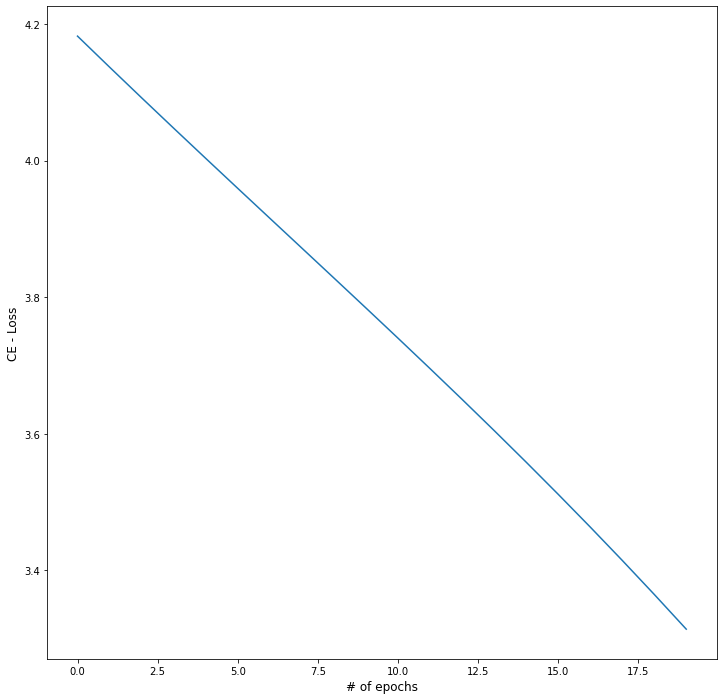

Last Output:  tensor([[ 0.1980, -0.0538, -0.0194,  0.1280, -0.1116, -0.0205, -0.2556, -0.1488,
         -0.1919,  0.0942,  0.1398, -0.2608,  0.4029,  0.1110, -0.2841, -0.0838,
         -0.0808, -0.0808, -0.1033,  0.2159, -0.3638, -0.0933,  0.2076,  0.0664,
         -0.1343,  0.1058, -0.1157,  0.2689, -0.1321, -0.0088, -0.0929,  0.0932,
          0.0103, -0.2244, -0.0203, -0.3138, -0.1308,  0.1610,  0.0530, -0.1401,
          0.0543, -0.0597,  0.2261, -0.0398, -0.2091, -0.0219, -0.0593,  0.2413,
         -0.0228,  0.0789,  0.0790, -0.2553,  0.0477, -0.1935, -0.1930, -0.1498,
         -0.1287, -0.1787, -0.1480,  0.1305],
        [ 0.2060,  0.1831, -0.3431, -0.0273, -0.0360,  0.1427, -0.0487, -0.1122,
         -0.0910,  0.1935, -0.1512, -0.1774,  0.0409, -0.2532,  0.2465,  0.2728,
         -0.3141,  0.1985, -0.0588,  0.2525, -0.1591, -0.5165, -0.2155,  0.2668,
         -0.0938, -0.0680,  0.0899, -0.1688, -0.0510, -0.0066,  0.0600,  0.0353,
         -0.1124, -0.1392,  0.0183,  0.0450,  0.0

In [18]:
 # Ensure net in training mode
net.train()

for epoch_i in range(N_EPOCHS):

    # Zero out gradients
    optimizer.zero_grad()
    
    # Get net output, calculate loss, and generate gradients
    output = net(data.X)
    loss = criterion(output, data.y)

    # Generate gradients via autograd
    loss.backward() 
    
    # Step
    # -----------------------------------
    # Clip params
    for param in net.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    
    # Track loss
    # CE loss
    losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, data.string[0], num_steps=len(data.string))
        
        if seq_i == data.string:
            end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    if end_early:
        print(f"\nEnding early. Converged in {epoch_i} epochs.")
        break
        

plt.figure(figsize=(12,12))
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()
print("Last Output: ", output)

### Questions
- Do we really need all these epochs? Try tweaking hidden and LR? What's the expected outcome.
- What's the final output? How do we get predictions. Can we calculate accuracy?
- Qualitative early stopping. In the future what?
- Better use a function to wrap-around...

In [9]:
def get_accuracy(y_true, y_pred):
    """
    Simple utility function to get the accuracy given the tensors with the true values (y_true) and
    a tensor with logits or probas.
    Input:
    - y_true: torch.Tensor,
    shape N, containing the class index for N samples
    - y_pred: torch.Tensor,
    shape N x num_classes, containing logit / probas values on each cell for the corresponding class per sample
    Output: accuracy, float range 0-1
    """
    return (y_pred.argmax(dim=1) == y_true).sum().item() / float(len(y_true))
print(f'Accuracy: {100 * get_accuracy(data.y, output):.2f} %')

Accuracy: 75.00 %


In [10]:
# To get probas from logits we can use the F.softmax function
# Get sorted probas per class for first input. First input was 'h' and we expect the most probable value to be 'e'
sorted_values, sorted_class_indexes = F.softmax(output[0,:], dim=0).sort(descending=True)

for i, class_index in enumerate(sorted_class_indexes.data.numpy()):
    print(f'Class: ({class_index}) {data.idx_to_char[class_index]} : {100*sorted_values[i]:.2f} %')

Class: (12) e : 2.55 %
Class: (27) t : 2.23 %
Class: (47) N : 2.17 %
Class: (42) I : 2.13 %
Class: (19) l : 2.11 %
Class: (22) o : 2.09 %
Class: (0)   : 2.07 %
Class: (37) D : 2.00 %
Class: (10) c : 1.96 %
Class: (59) Z : 1.94 %
Class: (3) ; : 1.93 %
Class: (13) f : 1.90 %
Class: (25) r : 1.89 %
Class: (9) b : 1.87 %
Class: (31) x : 1.87 %
Class: (50) Q : 1.84 %
Class: (49) P : 1.84 %
Class: (23) p : 1.82 %
Class: (40) G : 1.80 %
Class: (38) E : 1.79 %
Class: (52) S : 1.78 %
Class: (32) y : 1.72 %
Class: (29) v : 1.69 %
Class: (2) , : 1.67 %
Class: (34) A : 1.67 %
Class: (5) - : 1.67 %
Class: (45) L : 1.66 %
Class: (48) O : 1.66 %
Class: (43) J : 1.63 %
Class: (1) . : 1.61 %
Class: (46) M : 1.60 %
Class: (41) H : 1.60 %
Class: (17) j : 1.57 %
Class: (16) i : 1.57 %
Class: (15) h : 1.56 %
Class: (30) w : 1.55 %
Class: (21) n : 1.55 %
Class: (18) k : 1.53 %
Class: (4) ! : 1.52 %
Class: (26) s : 1.52 %
Class: (56) W : 1.50 %
Class: (36) C : 1.49 %
Class: (28) u : 1.49 %
Class: (24) q : 1.

#### Generate text

In [19]:
init_char = data.string[0]
print(f'Starting with letter: {init_char}')
net.generate(data, init_char, num_steps=len(data.string[0:]))

Starting with letter: h


'hello'

## Gradients explode or vanish 💣 - the curse of RNNs

While you are already used to thinking of neural networks as “deep” in the sense that many layers separate the input and output even within a single time step, the length of the sequence introduces a new notion of depth. In addition to the passing through the network in the input-to-output direction, inputs at the first time step must pass through a chain of T layers along the time steps in order to influence the output of the model at the final time step. Taking the backwards view, in each iteration, we backpropagate gradients through time, resulting in a chain of matrix-products with length O(T). This can result in numerical instability, causing the gradients to either explode or vanish depending on the properties of the weight matrices.

Dealing with vanishing and exploding gradients is a fundamental problem when designing RNNs and has inspired some of the biggest advances in modern neural network architectures. 

### Gradient Clipping (heuristic) for the rescue

This ensures that the gradient norm never exceeds the radius and that the updated gradient is entirely aligned with the original direction of gradient. It also has the desirable side-effect of limiting the influence any given minibatch (and within it any given sample) can exert on the parameter vector. This bestows a certain degree of robustness to the model. To be clear, it’s a hack. Gradient clipping means that we are not always following the true gradient and it’s hard to reason analytically about the possible side effects. However, it’s a very useful hack, and is widely adopted in RNN implementations in most deep learning frameworks.



# LSTM - Long Short-Term Memory


---


Although **gradient clipping** helps with **exploding gradients**, handling **vanishing gradients** appears to require a more elaborate solution. One of the first and most successful techniques for addressing vanishing gradients came in the form of the long short-term memory (LSTM) model due to Hochreiter and Schmidhuber (1997). LSTMs resemble standard recurrent neural networks but here each ordinary recurrent node is replaced by a **memory cell**. Each memory cell contains an internal state, i.e., a node with a self-connected recurrent edge of fixed weight 1, ensuring that the gradient can pass across many time steps without vanishing or exploding.


### Memory cell

Each memory cell is equipped with an internal state and a number of multiplicative gates that determine whether 
1. a given input should impact the internal state (the input gate), 
2. the internal state should be flushed to  (the forget gate), and 
3. the internal state of a given neuron should be allowed to impact the cell’s output (the output gate).

The data feeding into the LSTM gates are the input at the current time step and the hidden state of the previous time step, as illustrated in Fig. 10.1.1. Three fully connected layers with sigmoid activation functions compute the values of the input, forget, and output gates. As a result of the sigmoid activation, all values of the three gates are in the range of (0, 1). Additionally, we require an input node, typically computed with a tanh activation function. 

Intuitively:
- the input gate determines how much of the input node’s value should be added to the current memory cell internal state
- the forget gate determines whether to keep the current value of the memory or flush it
- the output gate determines whether the memory cell should influence the output at the current time step.

<img src="https://github.com/AI-team-UoA/Courses/blob/main/Deep-Learning-for-NLP-YS19/RNNs/images/fig1011.png?raw=true" width="700">


<img src="https://github.com/AI-team-UoA/Courses/blob/main/Deep-Learning-for-NLP-YS19/RNNs/images/lstm.png?raw=true" width="1000">


Link for more: https://d2l.ai/chapter_recurrent-modern/lstm.html

Question: What's the difference between Vanilla RNNs and LSTMs?

> The latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset. These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed. We discuss this in detail below.



## Implementation of LSTM from scratch

In [12]:
class LSTMCell(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        
        # Network Parameters
        # New cell content
        self.Wxh = nn.Parameter(torch.randn((num_features, num_hidden)))
        self.Whh = nn.Parameter(torch.randn((num_hidden, num_hidden)))
        self.bh = nn.Parameter(torch.zeros((num_hidden)))
        
        # Input gate parameters
        self.Wxh_i = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_i = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_i = nn.Parameter(torch.randn_like(self.bh))
        
        # Forget gate parameters
        self.Wxh_f = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_f = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_f = nn.Parameter(torch.randn_like(self.bh))
        
        # Output gate parameters
        self.Wxh_o = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_o = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_o = nn.Parameter(torch.randn_like(self.bh))
        
        # Hidden -> Output
        self.Why = nn.Parameter(torch.randn((num_hidden, self.num_classes)))
        self.by = nn.Parameter(torch.zeros((self.num_classes))) 
        
        # Activations
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def init(self):
        self.h = torch.zeros((self.num_hidden))  # Hidden state
        self.c = torch.zeros((self.num_hidden))  # Cell state
        
    def forward(self, x):
        potential_input = self.tanh((x @ self.Wxh) + (self.h @ self.Whh + self.bh))
        
        # Gate updates
        input_gate = self.sigmoid((x @ self.Wxh_i) + (self.h @ self.Whh_i + self.bh_i))
        forget_gate = self.sigmoid((x @ self.Wxh_f) + (self.h @ self.Whh_f + self.bh_f))
        output_gate = self.sigmoid((x @ self.Wxh_o) + (self.h @ self.Whh_o + self.bh_o))
        
        # Update c and h
        self.c = self.c * forget_gate + potential_input * input_gate
        self.h = output_gate * self.tanh(self.c)
        
        y_output = self.h @ self.Why + self.by
        
        return y_output

## Update setup

Epoch 1/500 -- Loss: 4.1151 -- Network out: hDwJc
Epoch 11/500 -- Loss: 4.0250 -- Network out: hNbgm
Epoch 21/500 -- Loss: 3.9296 -- Network out: hloel
Epoch 31/500 -- Loss: 3.8114 -- Network out: hloel
Epoch 41/500 -- Loss: 3.6418 -- Network out: hello

Ending early. Converged in 40 epochs.


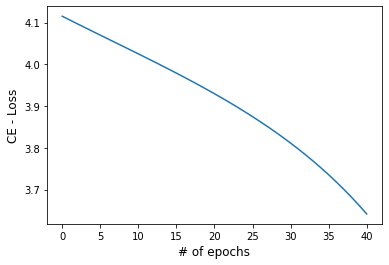

In [13]:
RNN.cells['LSTM'] = LSTMCell
CELL_TYPE = 'LSTM'
num_hidden = 50
net = RNN(num_features=data.num_characters, 
          num_hidden=num_hidden, 
          cell_type=CELL_TYPE)

LR = 0.001

optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
losses = []

N_EPOCHS = 500
print_every_ = 10
end_early = False
seq_i = ""


 # Ensure net in training mode
net.train()

for epoch_i in range(N_EPOCHS):

    # Zero out gradients
    optimizer.zero_grad()
    
    # Get net output, calculate loss, and generate gradients
    output = net(data.X)
    loss = criterion(output, data.y)

    # Generate gradients via autodiff
    loss.backward() 
    
    # Step
    # -----------------------------------
    # Clip params
    for param in net.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    
    # Track loss
    # CE loss
    losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, data.string[0], num_steps=len(data.string))
        
        if seq_i == data.string:
            end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    if end_early:
        print(f"\nEnding early. Converged in {epoch_i} epochs.")
        break
    
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

# GRU - Gated Recurrent Units


---


The gated recurrent unit (GRU) (Cho et al., 2014) offered a streamlined version of the LSTM memory cell that often achieves comparable performance but with the advantage of being faster to compute.


LSTM’s three gates are replaced by two: 
- the reset gate and 
- the update gate. 

As with LSTMs, these gates are given sigmoid activations, forcing their values to lie in the interval (0,1). 


Intuitively, 
- the reset gate controls how much of the previous state we might still want to remember
- an update gate would allow us to control how much of the new state is just a copy of the old state. 

GRUs have the following two distinguishing features:

- Reset gates help capture short-term dependencies in sequences.
- Update gates help capture long-term dependencies in sequences.

<img src="https://github.com/AI-team-UoA/Courses/blob/main/Deep-Learning-for-NLP-YS19/RNNs/images/gru.png?raw=true" width="1000">

In [14]:
class GRUCell(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        
        # Network Parameters
        # Potential Input
        self.Wxh = nn.Parameter(torch.randn((num_features, num_hidden)))
        self.Whh = nn.Parameter(torch.randn((num_hidden, num_hidden)))
        self.bh = nn.Parameter(torch.zeros((num_hidden)))
        
        # Update gate parameters
        self.Wxh_u = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_u = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_u = nn.Parameter(torch.randn_like(self.bh))
        
        # Reset gate parameters
        self.Wxh_r = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_r = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_r = nn.Parameter(torch.randn_like(self.bh))
        
        # Hidden -> Output
        self.Why = nn.Parameter(torch.randn((num_hidden, self.num_classes)))
        self.by = nn.Parameter(torch.zeros((self.num_classes))) 
        
        # Activations
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def init(self):
        self.h = torch.zeros((self.num_hidden))  # Hidden state
        
    def forward(self, x):
        
        # Gate updates
        update_gate = self.sigmoid((x @ self.Wxh_u) + (self.h @ self.Whh_u + self.bh_u))
        reset_gate = self.sigmoid((x @ self.Wxh_r) + (self.h @ self.Whh_r + self.bh_r))
        
        potential_input = self.tanh((x @ self.Wxh) + (reset_gate @ self.Whh + self.bh))
        
        self.h = self.h * (1-update_gate) + (potential_input * update_gate)
        y_output = self.h @ self.Why + self.by
        
        return y_output

Configure the GRU training

Epoch 1/500 -- Loss: 4.2630 -- Network out: hMGMG
Epoch 11/500 -- Loss: 3.3905 -- Network out: hllll
Epoch 21/500 -- Loss: 2.6097 -- Network out: hllll
Epoch 31/500 -- Loss: 1.9793 -- Network out: hllll
Epoch 41/500 -- Loss: 1.5481 -- Network out: hllll
Epoch 51/500 -- Loss: 1.2567 -- Network out: hllll
Epoch 61/500 -- Loss: 1.0792 -- Network out: hllll
Epoch 71/500 -- Loss: 0.9534 -- Network out: hllll
Epoch 81/500 -- Loss: 0.8562 -- Network out: hllll
Epoch 91/500 -- Loss: 0.7737 -- Network out: helll
Epoch 101/500 -- Loss: 0.7003 -- Network out: hello

Ending early. Converged in 100 epochs.


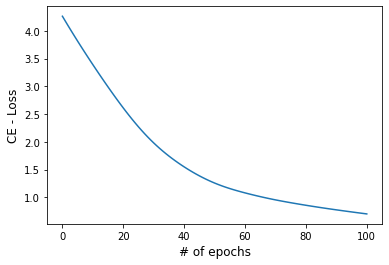

In [15]:
RNN.cells['GRU'] = GRUCell
CELL_TYPE = 'GRU'
num_hidden = 50
net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=CELL_TYPE)

LR = 0.001

optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
losses = []

N_EPOCHS = 500
print_every_ = 10
end_early = False
seq_i = ""


 # Ensure net in training mode
net.train()
for epoch_i in range(N_EPOCHS):
    # Zero out gradients
    optimizer.zero_grad()
    
    # Get net output, calculate loss, and generate gradients
    output = net(data.X)
    loss = criterion(output, data.y)
    # Generate gradients via autodiff
    loss.backward() 
    
    # Step
    # -----------------------------------
    # Clip params
    for param in net.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    
    # Track loss
    # CE loss
    losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, data.string[0], num_steps=len(data.string))
        
        if seq_i == data.string:
            end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    if end_early:
        print(f"\nEnding early. Converged in {epoch_i} epochs.")
        break
    
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

## Long-term dependecies

In [16]:
data = SequenceHandler('The quick brown fox jumps over the lazy dog')

Processed string: The quick brown fox jumps over the lazy dog --> The quick brown fox jumps over the lazy dog


In [17]:
N_EPOCHS = 500
LR = 0.01
num_hidden = 50

for CELL_TYPE in ['vanilla', 'LSTM', 'GRU']:
    print(f'Fitting {CELL_TYPE}...')
    net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=CELL_TYPE)
    optimizer = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    losses = []


    end_early = False
    seq_i = ""


    net.train() # Ensure net in training mode
    for epoch_i in range(N_EPOCHS):
        # Zero out gradients
        optimizer.zero_grad()

        # Get net output, calculate loss, and generate gradients
        output = net(data.X)
        loss = criterion(output, data.y)
        loss.backward() # Generate gradients via autodiff

        # Step
        # -----------------------------------
        # Clip params
        for param in net.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -5, 5)
        optimizer.step()
        # -----------------------------------

        # Track loss
        losses.append(loss.item())

        # Qualitative Eval
        if epoch_i % 10 == 0:
            seq_i = net.generate(data, data.string[0], num_steps=len(data.string))

            if seq_i == data.string:
                end_early = True

        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        # print(str_)
        # --------------------------------

        if end_early:
            print(f"\nEnding early. Converged in {epoch_i} epochs.")
            break
    str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
    print(str_)
    print('~'*50)

Fitting vanilla...

Ending early. Converged in 20 epochs.
Epoch 21/500 -- Loss: 0.4322 -- Network out: The quick brown fox jumps over the lazy dog
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting LSTM...

Ending early. Converged in 50 epochs.
Epoch 51/500 -- Loss: 0.2151 -- Network out: The quick brown fox jumps over the lazy dog
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting GRU...

Ending early. Converged in 40 epochs.
Epoch 41/500 -- Loss: 0.4050 -- Network out: The quick brown fox jumps over the lazy dog
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Questions

Why does this happen?
1. Try changing the learning rate (e.g. 0.08).
2. Did the results change? If yes why?

# Complexity comparison of Vanilla RNNs, LSTMs & GRUs

In [18]:
num_features, num_hidden, num_classes = 300, 500, 1
print('Number of Params:..')
for cell_type in ['vanilla', 'LSTM', 'GRU']:
    net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=cell_type)
    net_param_count = 0
    for name, param in net.named_parameters():
        if param.requires_grad:
            c = 1
            for val in param.shape:
                c *= val
        net_param_count += c
    print(f'{cell_type} : {net_param_count}')

Number of Params:..
vanilla : 310560
LSTM : 1152060
GRU : 871560


# Recap

- LSTM / GRU >> RNN. LSTM more effective, GRU more efficient.
- Use ReLUs and Adam as go to methods.
- Tweak hidden sizes and learning rates according to model performance during training.
- Better to create functions: def train(), def evaluate() ...  and also utilize already existing functionalities (Dataset and DataLoader from torch.utils) to avoid messy code and incosistencies.




# Other resources


- Book with accompanying torch code:
  - [Deep dive 2 deep learning: RRN Chapter](https://d2l.ai/chapter_recurrent-neural-networks/index.html)
- Posts:
    - [Karpathys famous blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) 
    - [Colah's blog post on LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    - [Explained extensive RNN post](https://explained.ai/rnn/index.html)
- Applications
    - [Surname classification with RNNs](https://github.com/joosthub/PyTorchNLPBook/blob/master/chapters/chapter_6/classifying-surnames/Chapter-6-Surname-Classification-with-RNNs.ipynb)
    - [LSTM with trainable word embeddings](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
    - [Emojifying sentences with Glove Embeddings](https://github.com/hiepnguyen034/Emojifier-plus)